In [87]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from rinarak.utils.os import load_json

local = True
dataset_dir = "/Users/melkor/Documents/datasets" if local else "datasets"

def normal_img(img):
    if len(img.shape) == 4:
        if not img.shape[1] in [1,3,4]: return img.permute(0,3,1,2)
    if len(img.shape) == 3:
        if not img.shape[0] in [1,3,4]: return img.permute(2,0,1)

def identiy_masks(img):
    return

class TDWRoomDataset(Dataset):
    def __init__(self,name="TDWRoom", split = "train", resolution = (128,128), root_dir = "datasets", motion_only = True):
        super().__init__()
        self.split = split
        self.root_dir = root_dir + f"/{name}"

        img_data_path = root_dir + f"/{name}"+ f"/{split}/img"
        self.files = os.listdir(img_data_path)

        """ add a working resolution to adapt different scenes and parameters"""
        self.transform = transforms.Resize(resolution)
        self.motion_only = motion_only
    
    def __len__(self):
        return len(self.files) // 4
    
    def __getitem__(self, idx):
        root_dir = self.root_dir
        split = self.split
        img_data_path = root_dir + f"/{self.split}/img"

        scene_data_path = root_dir + f"/{self.split}/scene/{idx}.json"
        scene_setup = load_json(scene_data_path)

        data = {}
        img = torch.tensor(plt.imread(img_data_path + f"/img_{idx}.png"))
        albedo = torch.tensor(plt.imread(img_data_path + f"/albedo_{idx}.png"))
        id_map = torch.tensor(plt.imread(img_data_path + f"/id_{idx}.png"))
        masks = np.load(img_data_path + f"/mask_{idx}.npy")
        ids_seq = np.load(root_dir + f"/{self.split}/scene/ids_{idx}.npy")
        #masks = torch.tensor(plt.imread(img_data_path + f"/id_{split}_{idx}.png"))
        
        for i,id in enumerate(ids_seq):
            #print( str(int(id)), scene_setup[str(int(id))]["model"], scene_setup[str(int(id))]["movable"])
            if self.motion_only and not scene_setup[str(int(id))]["movable"]:
                masks[torch.tensor(masks).int() == i] = 0


        data["img"] = self.transform(normal_img(img))
        data["albedo"] = self.transform(normal_img(albedo))
        data["masks"] =self.transform(torch.tensor(masks).unsqueeze(0)).squeeze(0)
        data["ids"] = id_map
        data["ids_sequence"] = ids_seq
        data["scene"] = scene_setup
        return data

In [103]:
asset_map = {
    "vase_05": {"color": "white", "texture": "plastic", "movable": True},
    "pot": {"color": "black", "texture": "metal", "movable": False},
    "jug03": {"color": "black", "texture": "metal", "movable": False},
}

In [109]:
def generate_vqa_pairs():
    return 

def break_predicates(category_predicate):
    pass

def collect_logic_tensor():
    pass



def preprocess(scene_setup, table = asset_map):
    for id in scene_setup:
        obj_info = scene_setup[id]
        if id != "camera" and id !="room_name":
            model_name= obj_info["model"]
            if model_name in table:
                for key in table[model_name]: obj_info[key] = table[model_name][key]
    return scene_setup

def generate_uniform_implication(concept_mask, concept_type = "namo"):
    question = [f"obj id is uniform in {concept_type}"]
    program = [f"( uniform (mask $0 movable) {concept_type})"]
    answer = ["true"]
    return question, program, answer

def generate_pair_implication(concept_mask, concept_type = "namo"):
    question = ["obj id1 and obj id2 are different in {concept_type}"]
    program = [f"{concept_type}"]
    answer = ["true"]
    return question, program, answer

def generate_single_scene(scene_setup, obj_library = None, num_unary = 3, num_binary = 3):
    scene_setup = preprocess(scene_setup)
    print(scene_setup)

    appeared_color = []
    appeared_texture = []

    obj_mask = []
    color_mask = []
    texture_mask = []
    category_mask = []
    movable_mask = []
    moving_mask = []

    

    for id in scene_setup:
        obj_info = scene_setup[id]
        if id != "camera" and id !="room_name":
            if "color" in obj_info:
                color_mask.append(obj_info["color"])
                appeared_color.append(obj_info["color"])
            else:color_mask.append("N/A")
            if "texture" in obj_info:
                texture_mask.append(obj_info["texture"])
                appeared_texture.append(obj_info["texture"])
            else:texture_mask.append("N/A")
            if "movable" in obj_info: movable_mask.append(obj_info["movable"])
            else:movable_mask.append("N/A")
            if "moving" in obj_info: moving_mask.append(obj_info["moving"])
            else:moving_mask.append("N/A")
            category_mask.append(obj_info["model"])
            #appeared_model.append(obj_info["model"])
    print(color_mask)
    print(texture_mask)
    print(movable_mask)
    print(moving_mask)
    print(category_mask)

    print("appeared_color",appeared_color)
    print("appeared_texture",appeared_texture)

    questions = []
    programs = []
    answers = []
    """handle the color concept"""
    for i in range(num_unary):
        q, p, a = generate_uniform_implication(color_mask, "albedo")
        questions.extend(q)
        programs.extend(p)
        answers.extend(a)
    for i in range(num_binary):
        q, p, a = generate_pair_implication(color_mask, "albedo")
        questions.extend(q)
        programs.extend(p)
        answers.extend(a)
    """handle the texture concept"""
    print(questions)
    print(programs)
    print(answers)
    return questions, programs, answers

idx = 0
name = "TDWKitchen"
split = "train"
scene_data_path = dataset_dir + f"/{name}/{split}/scene/{idx}.json"
scene_setup = load_json(scene_data_path)


generate_single_scene(scene_setup)

{'3211': {'model': 'dining_room_table', 'position': {'x': 0, 'y': 0, 'z': -0.2}, 'rotation': {'x': 0, 'y': 0, 'z': 0}, 'movable': False}, '12': {'model': 'chair_willisau_riale', 'position': {'x': 0, 'y': 0, 'z': 1.0999999999999999}, 'rotation': {'x': 0, 'y': 180, 'z': 0}, 'movable': False}, '122': {'model': 'chair_willisau_riale', 'position': {'x': -0.1, 'y': 0, 'z': -2.3000000000000025}, 'rotation': {'x': 0, 'y': 0, 'z': 0}, 'movable': False}, '124': {'model': 'basket_18inx18inx12iin_bamboo', 'position': {'x': 1, 'y': 0, 'z': 3}, 'rotation': {'x': 0, 'y': 0, 'z': 0}, 'movable': False}, '13': {'model': 'chair_willisau_riale', 'position': {'x': 0, 'y': 0, 'z': -1.0999999999999999}, 'rotation': {'x': 0, 'y': 0, 'z': 0}, 'movable': False}, '15': {'model': 'jug03', 'position': {'x': -0.2, 'y': 0.8, 'z': -0.1}, 'rotation': {'x': 0, 'y': 90, 'z': 0}, 'movable': True}, '17': {'model': 'glass1', 'position': {'x': 0.20000000000000004, 'y': 0.9, 'z': -0.5}, 'rotation': {'x': 0, 'y': 90, 'z': 0},

(['obj id is uniform in albedo',
  'obj id is uniform in albedo',
  'obj id is uniform in albedo',
  'obj id1 and obj id2 are different in {concept_type}',
  'obj id1 and obj id2 are different in {concept_type}',
  'obj id1 and obj id2 are different in {concept_type}'],
 ['( uniform (mask $0 movable) albedo)',
  '( uniform (mask $0 movable) albedo)',
  '( uniform (mask $0 movable) albedo)',
  'albedo',
  'albedo',
  'albedo'],
 ['true', 'true', 'true', 'true', 'true', 'true'])

{'3211': {'model': ['dining_room_table'], 'position': {'x': tensor([0]), 'y': tensor([0]), 'z': tensor([-0.2000], dtype=torch.float64)}, 'rotation': {'x': tensor([0]), 'y': tensor([0]), 'z': tensor([0])}, 'movable': tensor([False])}, '12': {'model': ['chair_willisau_riale'], 'position': {'x': tensor([0]), 'y': tensor([0]), 'z': tensor([1.1000], dtype=torch.float64)}, 'rotation': {'x': tensor([0]), 'y': tensor([180]), 'z': tensor([0])}, 'movable': tensor([False])}, '122': {'model': ['chair_willisau_riale'], 'position': {'x': tensor([-0.1000], dtype=torch.float64), 'y': tensor([0]), 'z': tensor([-2.3000], dtype=torch.float64)}, 'rotation': {'x': tensor([0]), 'y': tensor([0]), 'z': tensor([0])}, 'movable': tensor([False])}, '124': {'model': ['basket_18inx18inx12iin_bamboo'], 'position': {'x': tensor([1]), 'y': tensor([0]), 'z': tensor([3])}, 'rotation': {'x': tensor([0]), 'y': tensor([0]), 'z': tensor([0])}, 'movable': tensor([False])}, '13': {'model': ['chair_willisau_riale'], 'position'

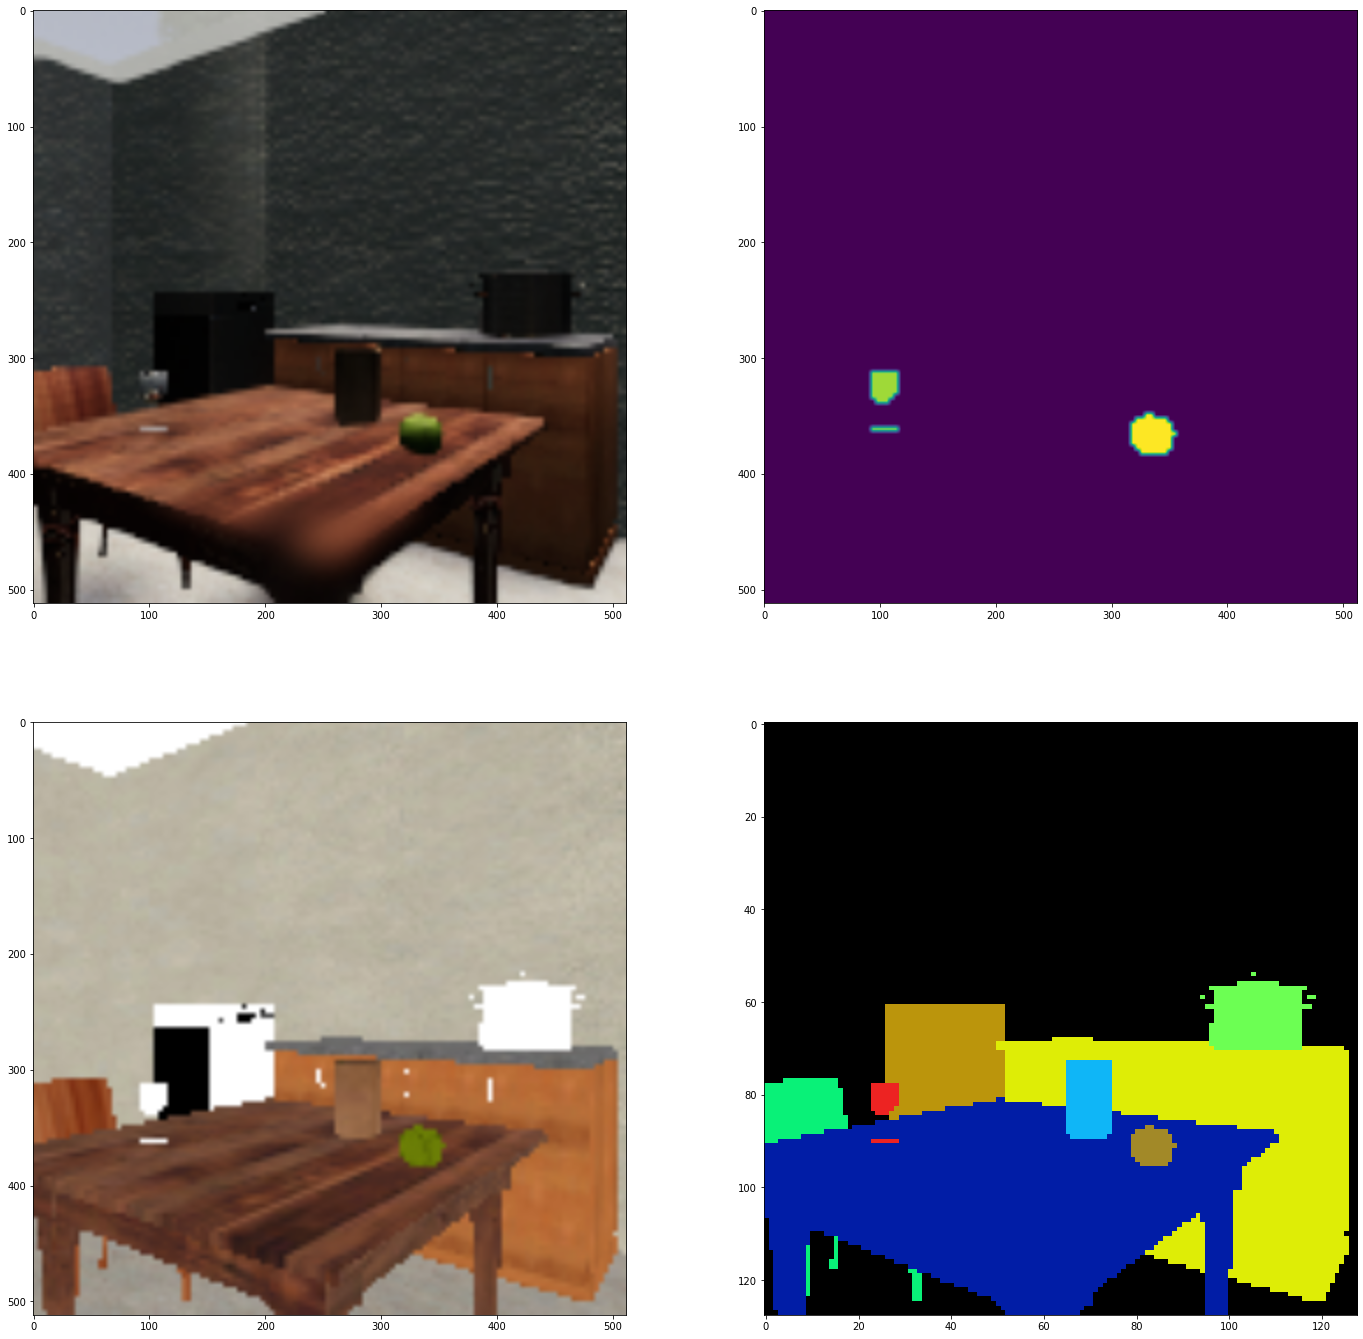

In [95]:
resolution = (512,512)
W, H = resolution
B, N= 1, W * H

name = "TDWKitchen"
dataset = TDWRoomDataset(name,resolution = resolution, root_dir = dataset_dir, split = "train", motion_only=True)
loader = torch.utils.data.DataLoader(dataset, batch_size = B, shuffle = 1)
for sample in loader:break;
"""load the dataset and make the ideal images and masks"""

ims = sample["img"]
target_masks = sample["masks"]
albedo = sample["albedo"]
id_map = sample["ids"]
id_seq = sample["ids_sequence"]
scene = sample["scene"]
print(scene)

plt.figure("visalize", figsize=(24,24))
plt.subplot(221)
plt.imshow(ims[0].permute(1,2,0))
plt.subplot(222)
plt.imshow(target_masks[0])
plt.subplot(223)
plt.imshow(albedo[0].permute(1,2,0))
plt.subplot(224)
plt.imshow(id_map[0])
plt.show()